In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.nn.init as I


def init_weights(m):
  
    if isinstance(m, nn.Conv2d):
        I.kaiming_uniform_(m.weight, nonlinearity='relu')
        

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        

        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        
       
        self.max_pool = nn.MaxPool2d(3,3)
        self.conv_bn = nn.BatchNorm2d(64)
        
        self.drop_out1 = nn.Dropout2d(0.1)
        self.drop_out2 = nn.Dropout2d(0.2)
        self.drop_out3 = nn.Dropout2d(0.3)
       
        
        self.fc_bn = nn.BatchNorm1d(512)
        
        self.fc1 = nn.Linear(6272,512)
        self.fc2 = nn.Linear(512,136)
       
        

        
    def forward(self, x):
        x = self.drop_out1(self.max_pool(F.relu(self.conv1(x))))
        x = self.drop_out2(self.max_pool(F.relu(self.conv_bn(self.conv2(x)))))
        x = self.drop_out3(self.max_pool(F.relu(self.conv3(x))))
        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc_bn(self.fc1(x)))
        x = self.fc2(x)
        
        return x

In [2]:
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /data/test/Elmar_Brok_21.jpg  
  inflating: /data/test/Elmar_Brok_30.jpg  
  inflating: /data/test/Elmar_Brok_31.jpg  
  inflating: /data/test/Elsa_Zylberstein_00.jpg  
  inflating: /data/test/Elsa_Zylberstein_01.jpg  
  inflating: /data/test/Elsa_Zylberstein_10.jpg  
  inflating: /data/test/Elsa_Zylberstein_11.jpg  
  inflating: /data/test/Elsa_Zylberstein_40.jpg  
  inflating: /data/test/Elsa_Zylberstein_41.jpg  
  inflating: /data/test/Elton_John_10.jpg  
  inflating: /data/test/Elton_John_11.jpg  
  inflating: /data/test/Elton_John_20.jpg  
  inflating: /data/test/Elton_John_21.jpg  
  inflating: /data/test/Elton_John_30.jpg  
  inflating: /data/test/Elton_John_31.jpg  
  inflating: /data/test/Elton_John_40.jpg  
  inflating: /data/test/Elton_John_41.jpg  
  inflating: /data/test/Emile_Lahoud_00.jpg  
  inflating: /data/test/Emile_Lahoud_01.jpg  
  inflating: /data/test/Emile_Lahoud_30.jpg  
  inflatin

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:
    from workspace_utils import active session
    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:
    from workspace_utils import keep_awake
    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

%load_ext autoreload
%autoreload 2

In [4]:

import torch
import torch.nn as nn
import torch.nn.functional as F


net = Net()
net.apply(init_weights)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_out1): Dropout2d(p=0.1, inplace=False)
  (drop_out2): Dropout2d(p=0.2, inplace=False)
  (drop_out3): Dropout2d(p=0.3, inplace=False)
  (fc_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=136, bias=True)
)


In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import cv2


class FacialKeypointsDataset(Dataset):


    def __init__(self, csv_file, root_dir, transform=None):

        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample
    


class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        image_copy=  image_copy/255.0
            
        
      
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        if(len(image.shape) == 2):
            
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
       
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

data_transform = transforms.Compose([Rescale((224,224)),Normalize(),ToTensor()])

assert(data_transform is not None), 'Define a data_transform'

In [6]:
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [7]:
batch_size = 15

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [8]:
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)

In [9]:
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [10]:
def net_sample_output():
    

    for i, sample in enumerate(test_loader):
        
        images = sample['image']
        key_pts = sample['keypoints']


        images = images.type(torch.FloatTensor)

        output_pts = net(images)
        

        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        

        if i == 0:
            return images, output_pts, key_pts

In [11]:

test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):

   
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
  
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

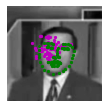

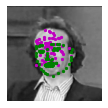

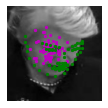

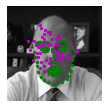

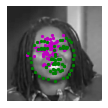

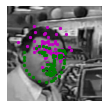

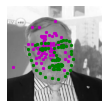

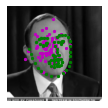

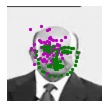

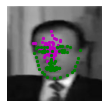

In [13]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

      
        image = test_images[i].data   
        image = image.numpy() 
        image = np.transpose(image, (1, 2, 0))  

        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()

        predicted_key_pts = predicted_key_pts*50.0+100
        

        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        

        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        
        plt.axis('off')

    plt.show()
    
visualize_output(test_images, test_outputs, gt_pts)

In [14]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [15]:
def train_net(n_epochs):

   
    net.train()

    for epoch in range(n_epochs):  
        running_loss = 0.0
       
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']

        
            key_pts = key_pts.view(key_pts.size(0), -1)

            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            output_pts = net(images)
            loss = criterion(output_pts, key_pts)

            optimizer.zero_grad()
          
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if batch_i % 10 == 9:    
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')

In [16]:
n_epochs = 35

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.27865503430366517
Epoch: 1, Batch: 20, Avg. Loss: 0.16484321504831315
Epoch: 1, Batch: 30, Avg. Loss: 0.12859310060739518
Epoch: 1, Batch: 40, Avg. Loss: 0.10970878079533578
Epoch: 1, Batch: 50, Avg. Loss: 0.10147975981235505
Epoch: 1, Batch: 60, Avg. Loss: 0.10931803286075592
Epoch: 1, Batch: 70, Avg. Loss: 0.08274549692869186
Epoch: 1, Batch: 80, Avg. Loss: 0.09127067849040031
Epoch: 1, Batch: 90, Avg. Loss: 0.08758170194923878
Epoch: 1, Batch: 100, Avg. Loss: 0.08981862664222717
Epoch: 1, Batch: 110, Avg. Loss: 0.08849495947360993
Epoch: 1, Batch: 120, Avg. Loss: 0.0744884591549635
Epoch: 1, Batch: 130, Avg. Loss: 0.07049872875213622
Epoch: 1, Batch: 140, Avg. Loss: 0.07935899086296558
Epoch: 1, Batch: 150, Avg. Loss: 0.07669695019721985
Epoch: 1, Batch: 160, Avg. Loss: 0.07285677827894688
Epoch: 1, Batch: 170, Avg. Loss: 0.07043711505830288
Epoch: 1, Batch: 180, Avg. Loss: 0.06729808263480663
Epoch: 1, Batch: 190, Avg. Loss: 0.07261745855212212
Epo

In [17]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


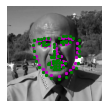

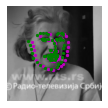

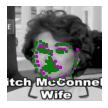

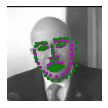

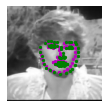

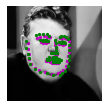

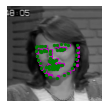

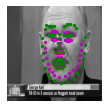

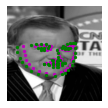

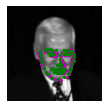

In [18]:
visualize_output(test_images, test_outputs, gt_pts)